# Trees - AVL Trees

---

An AVL tree is a self-balancing binary search tree (BST) in which the height difference between the left and right subtrees of any node, known as its balance factor, is at most 1.

## Key characteristics    

* Self-balancing: It automatically performs rotations to maintain a balanced structure, unlike a standard binary search tree.  
* Balance factor: The difference in height between the left and right subtrees of any node is always $-1$, $0$, or $1$.  
* Time complexity: The self-balancing nature guarantees efficient performance, with all search, insertion, and deletion operations taking $O(\log n)$ time. 

## Core Idea

* Maintaining balance: When an insertion or deletion causes the balance factor of a node to become greater than one, the tree performs a series of rotations (LL, RR, LR, RL) to restore the balance. 
* Node structure: Each node stores its value, pointers to its left and right children, and its height, which is crucial for checking the balance factor. 

## Rotations

There are four types of rotations used to fix imbalances: 
* Left-Left (LL): A right rotation is performed when the tree is unbalanced on the left. 
* Right-Right (RR): A left rotation is performed when the tree is unbalanced on the right. 
* Left-Right (LR): A left rotation is performed on the left child, followed by a right rotation on the parent node. 
* Right-Left (RL): A right rotation is performed on the right child, followed by a left rotation on the parent node. 

**LL** 

```python
Before (balance > 1):          After:
       Y (2)                      X (2)
      /                           /  \
     X (1)              ->       A    Y (1)
    /  \                               / \
   A    B                             B   C
        /
       C
```

**RR**
```python
Before (balance < -1):          After:
     X (2)                        Y (2)
      \                           /  \
       Y (1)             ->       X   C
      /  \                     / \
     B    C                   A   B
    /
   A
```

**LR**
```python
Before:                          Step 1:                       Step 2:
       Y (3)                      Y (2)                        Z (2)
      /                           / \                          / \
     X (2)              ->       Z   X (1)           ->      Y   X (1)
      \                         / \ / \                      / \ / \
       Z (1)                  B  Y C  D                    Z B C D
      / \
     B   C
```

**RL**
```python
Before:                          Step 1:                       Step 2:
   X (3)                          X (2)                        Z (2)
    \                            / \                          / \
     Y (2)              ->      Y   Z (1)            ->      Y   X (1)
    /                         / \ / \                      / \ / \
   Z (1)                     D  X E  F                     Z D E F
     \   \
      E  F

```

## Implementation

In [1]:
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import networkx as nx

from theoria.validor import TestCase, Validor

In [2]:
@dataclass
class AVLNode:
    val: int
    left: Optional["AVLNode"] = None
    right: Optional["AVLNode"] = None
    height: int = 1


class AVLTree:
    def height(self, node: Optional[AVLNode]) -> int:
        return node.height if node else 0

    def balance_factor(self, node: Optional[AVLNode]) -> int:
        return self.height(node.left) - self.height(node.right)

    def update_height(self, node: AVLNode):
        node.height = 1 + max(self.height(node.left), self.height(node.right))

    # ========== SINGLE ROTATIONS ==========
    def right_rotate_ll(self, node: AVLNode) -> AVLNode:
        """LL Case: Left-Left imbalance -> Right rotation"""
        new_root = node.left
        node.left = new_root.right
        new_root.right = node
        self.update_height(node)
        self.update_height(new_root)
        return new_root

    def left_rotate_rr(self, node: AVLNode) -> AVLNode:
        """RR Case: Right-Right imbalance -> Left rotation"""
        new_root = node.right
        node.right = new_root.left
        new_root.left = node
        self.update_height(node)
        self.update_height(new_root)
        return new_root

    # ========== DOUBLE ROTATIONS ==========
    def left_right_lr(self, node: AVLNode) -> AVLNode:
        """LR Case: Left-Right imbalance -> Left + Right rotations"""
        node.left = self.left_rotate_rr(node.left)  # First: Left rotate child
        return self.right_rotate_ll(node)  # Then: Right rotate parent

    def right_left_rl(self, node: AVLNode) -> AVLNode:
        """RL Case: Right-Left imbalance -> Right + Left rotations"""
        node.right = self.right_rotate_ll(node.right)  # First: Right rotate child
        return self.left_rotate_rr(node)  # Then: Left rotate parent

    # ========== MAIN INSERT ==========
    def insert(self, root: Optional[AVLNode], val: int) -> Optional[AVLNode]:
        if not root:
            return AVLNode(val)

        # BST insert
        if val < root.val:
            root.left = self.insert(root.left, val)
        elif val > root.val:
            root.right = self.insert(root.right, val)
        else:
            return root  # No duplicates

        self.update_height(root)
        balance = self.balance_factor(root)

        # ========== CALL SPECIFIC ROTATION FUNCTIONS ==========
        # Left Heavy (balance > 1)
        if balance > 1:
            if val < root.left.val:  # LL
                return self.right_rotate_ll(root)
            else:  # LR
                return self.left_right_lr(root)

        # Right Heavy (balance < -1)
        if balance < -1:
            if val > root.right.val:  # RR
                return self.left_rotate_rr(root)
            else:  # RL
                return self.right_left_rl(root)

        return root

    def visualise(self, root: Optional["AVLNode"]):
        if not root:
            return

        g = nx.DiGraph()
        pos: Dict[str, Tuple[float, float]] = {}

        def build_tree(node: "AVLNode", x: float, y: float, dx: float):
            node_id = f"n{node.val}"
            balance = self.balance_factor(node)
            g.add_node(node_id, label=f"{node.val}\nh={node.height}\nb={balance}")
            pos[node_id] = (x, y)

            child_dx = dx / 2.5
            if node.left:
                g.add_edge(node_id, f"n{node.left.val}")
                build_tree(node.left, x - child_dx, y - 1, child_dx)
            if node.right:
                g.add_edge(node_id, f"n{node.right.val}")
                build_tree(node.right, x + child_dx, y - 1, child_dx)

        max_dx = 2 ** (self.height(root) - 1)
        build_tree(root, 0, 0, max_dx)

        plt.figure(figsize=(4, 3))
        nx.draw_networkx_nodes(
            g, pos, node_color="lightblue", node_size=1200, alpha=1.0
        )
        nx.draw_networkx_edges(
            g, pos, arrows=True, arrowsize=15, edge_color="gray", width=1.5
        )
        nx.draw_networkx_labels(
            g,
            pos,
            labels=nx.get_node_attributes(g, "label"),
            font_size=9,
        )

        plt.title("AVL Tree Visualization", fontsize=14)
        plt.axis("off")
        plt.xlim(
            min(x for x, y in pos.values()) - 1, max(x for x, y in pos.values()) + 1
        )
        plt.ylim(
            min(y for x, y in pos.values()) - 1, max(y for x, y in pos.values()) + 1
        )
        plt.tight_layout()
        plt.show()

## Visualisation

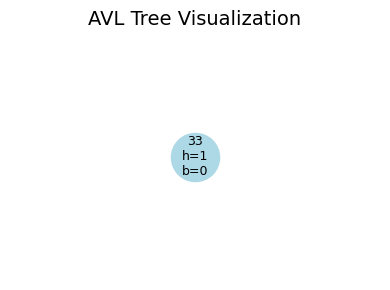

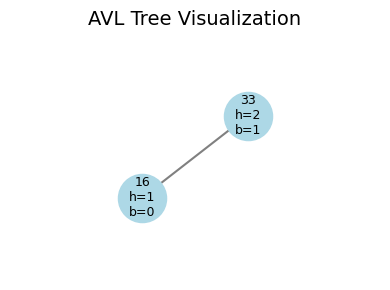

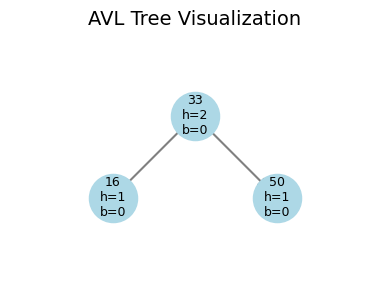

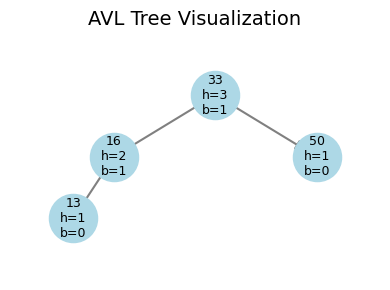

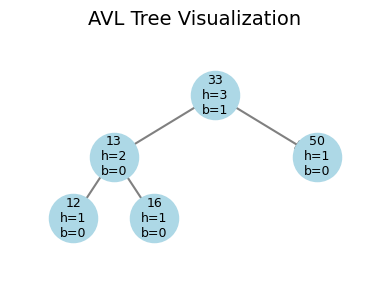

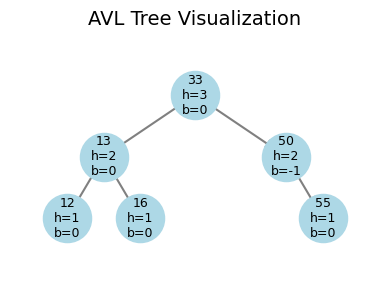

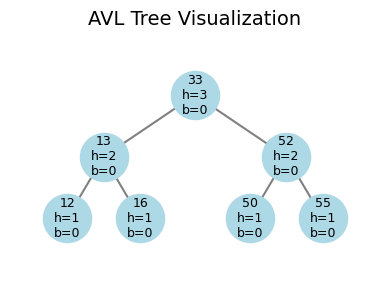

In [3]:
if __name__ == "__main__":
    tree = AVLTree()
    root = None

    # 1. Insert 33 - First node (h=1, b=0)
    root = tree.insert(root, 33)
    tree.visualise(root)  # h=1, b=0

    # 2. Insert 16 - Left child (33: h=2, b=+1)
    root = tree.insert(root, 16)
    tree.visualise(root)  # h=2, b=+1

    # 3. Insert 50 - Right child (33: h=3, b=0)
    root = tree.insert(root, 50)
    tree.visualise(root)  # h=3, b=0

    # 4. Insert 13 - LL CASE (16: h=2->+2 -> Right rotation)
    root = tree.insert(root, 13)
    tree.visualise(root)  # h=3, b=0 (LL fixed)

    # 5. Insert 12 - LR CASE (13: h=2->+2 wrong side -> Double rotation)
    root = tree.insert(root, 12)
    tree.visualise(root)  # h=4, b=0 (LR fixed)

    # 6. Insert 55 - RR CASE (50: h=2->-2 -> Left rotation)
    root = tree.insert(root, 55)
    tree.visualise(root)  # h=4, b=0 (RR fixed)

    # 7. Insert 52 - RL CASE (55: h=2->-2 wrong side -> Double rotation)
    root = tree.insert(root, 52)
    tree.visualise(root)  # h=5, b=0 (RL fixed)

## Tests

In [4]:
def compute_avl_properties(values: List[int]) -> Dict[str, Any]:
    tree = AVLTree()
    root = None
    for val in values:
        root = tree.insert(root, val)

    # Compute all possible outputs
    inorder = []

    def collect(node):
        if node:
            collect(node.left)
            inorder.append(node.val)
            collect(node.right)

    collect(root)

    return {
        "root_val": root.val if root else None,
        "height": root.height if root else 0,
        "balance": tree.balance_factor(root),
        "left_child": root.left.val if root and root.left else None,
        "right_child": root.right.val if root and root.right else None,
        "inorder_sorted": inorder == sorted(values),
    }


test_cases = [
    TestCase(
        input_data={"values": [33]},
        expected_output={"root_val": 33, "balance": 0},
        description="Single node: h=1, b=0",
    ),
    TestCase(
        input_data={"values": [30, 20, 10]},
        expected_output={
            "root_val": 20,
            "left_child": 10,
            "right_child": 30,
            "balance": 0,
        },
        description="LL rotation: 30->20->10",
    ),
    TestCase(
        input_data={"values": [30, 20, 25]},
        expected_output={
            "root_val": 25,
            "left_child": 20,
            "right_child": 30,
            "balance": 0,
        },
        description="LR rotation: 30->20->25",
    ),
    TestCase(
        input_data={"values": [10, 20, 30]},
        expected_output={
            "root_val": 20,
            "left_child": 10,
            "right_child": 30,
            "balance": 0,
        },
        description="RR rotation: 10->20->30",
    ),
    TestCase(
        input_data={"values": [10, 20, 15]},
        expected_output={
            "root_val": 15,
            "left_child": 10,
            "right_child": 20,
            "balance": 0,
        },
        description="RL rotation: 10->20->15",
    ),
    TestCase(
        input_data={"values": [50, 30, 20, 10, 40, 60, 70]},
        expected_output={"root_val": 30, "height": 4, "balance": -1},
        description="Multiple rotations: LL+RR chain",
    ),
    TestCase(
        input_data={"values": list(range(100))[::-1]},  # 99->0 (reverse sorted)
        expected_output={"height": 7},
        description="Worst-case sequential",
    ),
]


def comparison(actual: Dict[str, Any], expected: Dict[str, Any]) -> bool:
    # Only compare expected keys
    for key, val in expected.items():
        if key not in actual or actual[key] != val:
            return False
    return True


Validor(compute_avl_properties).add_cases(test_cases).run(comparison=comparison)

[2025-12-25 21:46:15,450] [INFO] All 7 tests passed for compute_avl_properties.
